# Setup

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Get Data

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Projects/Alphabet Classification/A_Z Handwritten Data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 2.2 GB


In [3]:
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O",
               "P", "Q", "R", "S", "T" "U", "V", "W", "X", "Y", "Z"]

In [4]:
sample = data.iloc[10].values

In [5]:
sample_label = sample[0]
sample = sample[1:].reshape(28,28)

Text(0.5, 1.0, 'A')

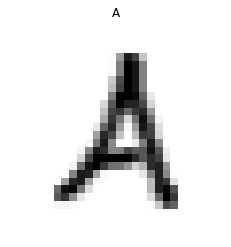

In [6]:
plt.imshow(sample, cmap="binary")
plt.axis('off')
plt.title(class_names[sample_label])

# Preprocessing

In [7]:
# Seperate labels 
labels = data['0'].values.astype('uint8')
X = data.drop('0', axis=1)
X.shape

(372450, 784)

In [8]:
labels

array([ 0,  0,  0, ..., 25, 25, 25], dtype=uint8)

In [9]:
# Reshape data
X = np.array(X).reshape(372450, 28, 28, 1)
X.shape

(372450, 28, 28, 1)

In [10]:
# split between train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size = 0.3, random_state = 42)

# scale images to [0, 1] range
X_train = X_train.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255

# Check image shape
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_valid.shape[0], "test samples")

x_train shape: (260715, 28, 28, 1)
260715 train samples
111735 test samples


# Image Augmentation

In [11]:
# Slight image augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.05),
  layers.experimental.preprocessing.RandomContrast(0.10),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.05,0.05))
])

# Modeling

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

keras.backend.clear_session()
tf.random.set_seed(12)
np.random.seed(12)

num_classes = 26
epochs = 15

# Callbacks
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0002,
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

model = keras.models.Sequential([
    data_augmentation,
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics = ["accuracy"])

history = model.fit(X_train, y_train, epochs=epochs, callbacks= [reduce_lr, model_checkpoint_callback, es_callback], validation_data=(X_valid, y_valid))

Epoch 1/15
8148/8148 [==============================] - 65s 6ms/step - loss: 0.3590 - accuracy: 0.9010 - val_loss: 0.0951 - val_accuracy: 0.9775
Epoch 2/15
8148/8148 [==============================] - 48s 6ms/step - loss: 0.1707 - accuracy: 0.9562 - val_loss: 0.0808 - val_accuracy: 0.9817
Epoch 3/15
8148/8148 [==============================] - 48s 6ms/step - loss: 0.1419 - accuracy: 0.9641 - val_loss: 0.0749 - val_accuracy: 0.9836
Epoch 4/15
8148/8148 [==============================] - 48s 6ms/step - loss: 0.1255 - accuracy: 0.9683 - val_loss: 0.0697 - val_accuracy: 0.9857
Epoch 5/15
8148/8148 [==============================] - 49s 6ms/step - loss: 0.1146 - accuracy: 0.9711 - val_loss: 0.0705 - val_accuracy: 0.9845
Epoch 6/15
8148/8148 [==============================] - 48s 6ms/step - loss: 0.1098 - accuracy: 0.9726 - val_loss: 0.0674 - val_accuracy: 0.9853
Epoch 7/15
8148/8148 [==============================] - 48s 6ms/step - loss: 0.1046 - accuracy: 0.9738 - val_loss: 0.0639 - val_ac

In [13]:
model.evaluate(X_valid, y_valid)

3492/3492 [==============================] - 7s 2ms/step - loss: 0.0656 - accuracy: 0.9877


[0.06563118100166321, 0.9876940846443176]

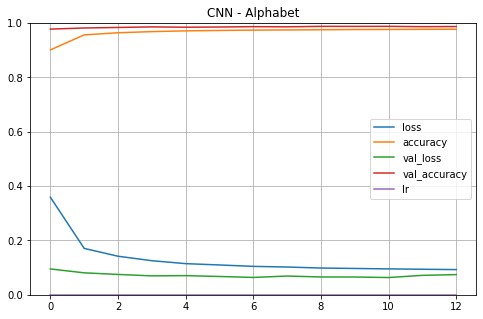

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("CNN - Alphabet")
plt.show()

In [15]:
model.save('alphabet_cnn.h5')